# Import libraries

In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import pandas as pd
import os
from PIL import Image
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

#  Define data directories

In [2]:
train_dir = r'C:\Users\Lap Top\DeepFake\Dataset\Train'
valid_dir = r'C:\Users\Lap Top\DeepFake\Dataset\Validation'
test_dir = r'C:\Users\Lap Top\DeepFake\Dataset\Test'

# Function to view random images from specified classes

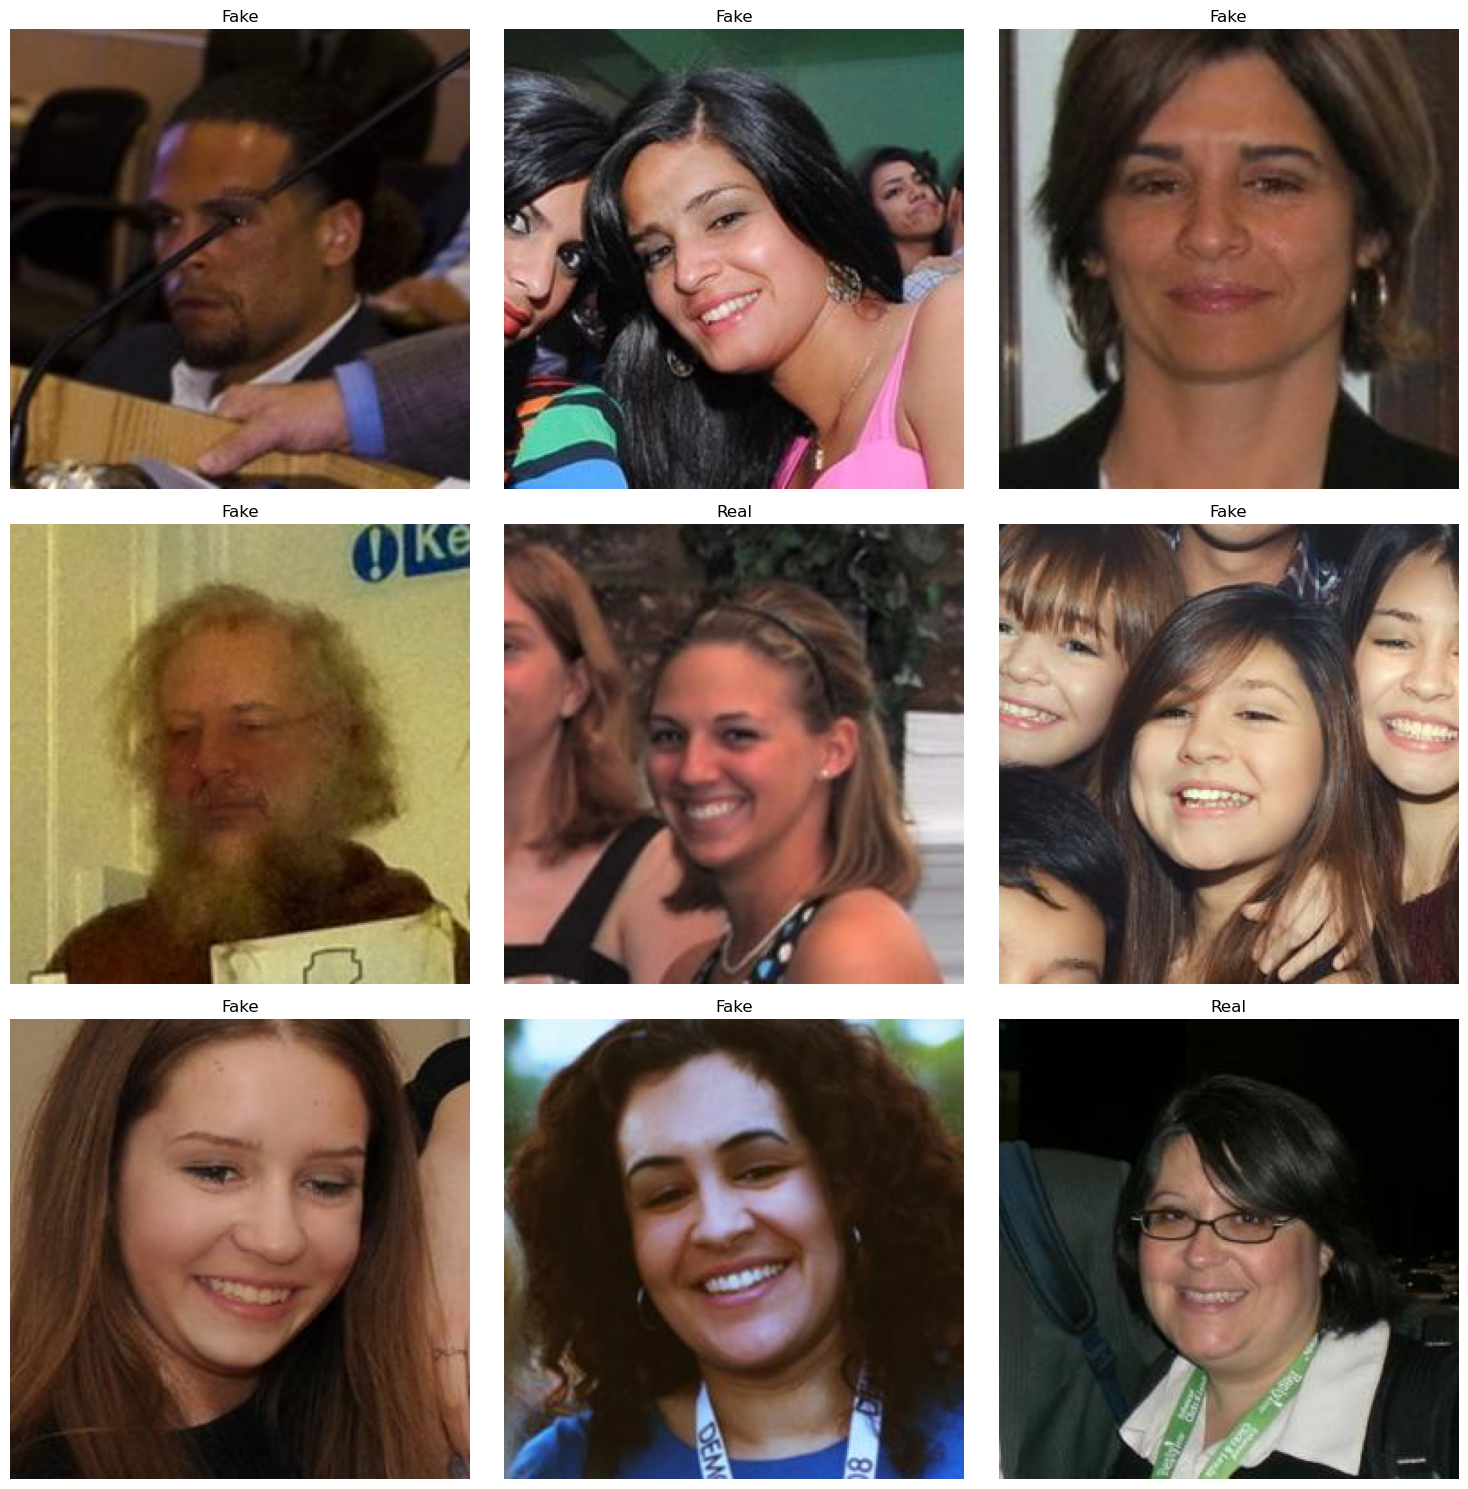

In [7]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(target_dir, target_classes, num_images=9):
    """View a specified number of random images from a list of target classes."""
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        target_class = random.choice(target_classes)
        target_folder = os.path.join(target_dir, target_class)
        all_images = os.listdir(target_folder)
        if all_images:
            random_image = random.choice(all_images)
            img_path = os.path.join(target_folder, random_image)
            img = mpimg.imread(img_path)
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(target_class)
            plt.axis('off')
        else:
            print(f"No images found in class: {target_class}")
    plt.tight_layout()
    plt.show()

# Example usage: View 9 random images from 'Real' and 'Fake' classes in the training directory
view_random_images(target_dir=train_dir, target_classes=["Real", "Fake"], num_images=9)

# Create ImageDataGenerators for data augmentation and loading

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                target_size=(224, 224),
                                                class_mode="binary",
                                                seed=42)
valid_data = valid_datagen.flow_from_directory(valid_dir,
                                                batch_size=32,
                                                target_size=(224, 224),
                                                class_mode="binary",
                                                seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                                batch_size=1,
                                                target_size=(224, 224),
                                                class_mode="binary",
                                                shuffle=False,
                                                seed=42)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


# Define the InceptionV3-based model

In [9]:
input_shape=(224,224,3)
batch_size=64
def build_model_inception():
    inception = InceptionV3(
                            weights='imagenet',
                            include_top=False,
                            input_shape=input_shape,
                            )
    model = Sequential([inception,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(256,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                  )
    return model

model_icv3 = build_model_inception()
model_icv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_94 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_95 (Bat  (None, 256)              1

# Train the model with EarlyStopping and ModelCheckpoint

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('DeepFake_best_model_inception.h5', save_best_only=True, monitor='val_loss')

history_icv3 = model_icv3.fit(
    train_data,
    epochs=15,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/15
4376/4376 [==============================] - 1343s 303ms/step - loss: 0.1576 - accuracy: 0.9391 - val_loss: 0.1105 - val_accuracy: 0.9592
Epoch 2/15
4376/4376 [==============================] - 1367s 312ms/step - loss: 0.0747 - accuracy: 0.9725 - val_loss: 0.0711 - val_accuracy: 0.9735
Epoch 3/15
4376/4376 [==============================] - 1284s 293ms/step - loss: 0.0618 - accuracy: 0.9765 - val_loss: 0.0782 - val_accuracy: 0.9708
Epoch 4/15
4376/4376 [==============================] - 1370s 313ms/step - loss: 0.0554 - accuracy: 0.9797 - val_loss: 0.0690 - val_accuracy: 0.9752
Epoch 5/15
4376/4376 [==============================] - 1300s 297ms/step - loss: 0.0504 - accuracy: 0.9807 - val_loss: 0.0574 - val_accuracy: 0.9797
Epoch 6/15
4376/4376 [==============================] - 1351s 309ms/step - loss: 0.0463 - accuracy: 0.9829 - val_loss: 0.0652 - val_accuracy: 0.9778
Epoch 7/15
4376/4376 [==============================] - 1288s 294ms/step - loss: 0.0418 - accuracy: 0.9840

# Function to plot accuracy and loss

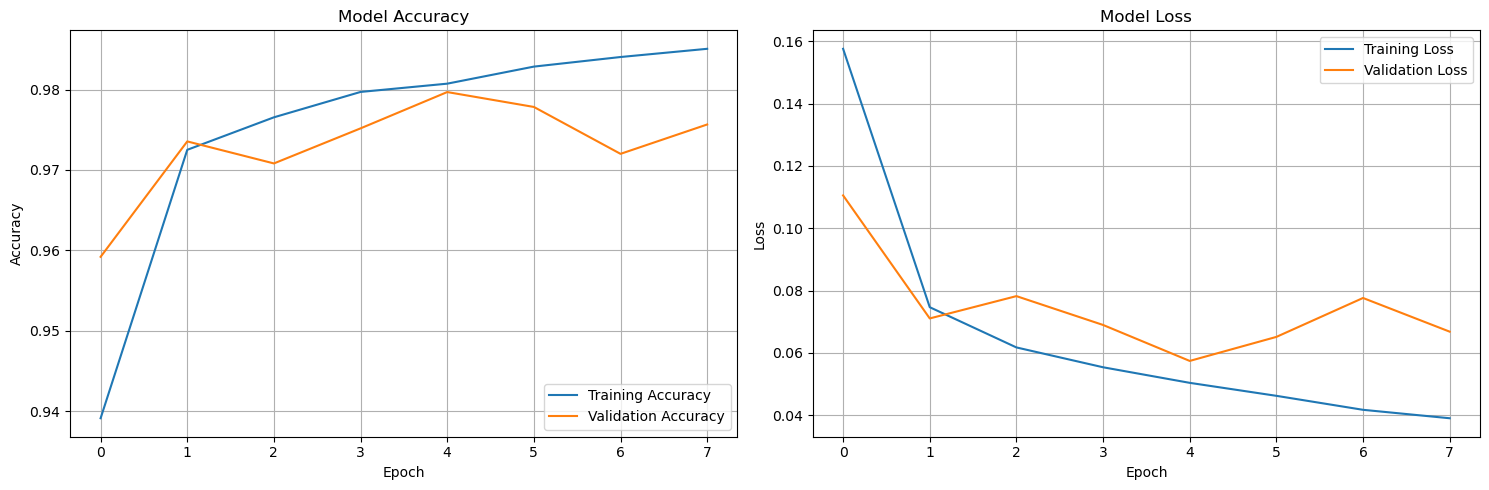

In [37]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    """Plot the accuracy and loss curves for training and validation data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Cell 11: After training, call the function to plot the results
# Assuming you have a 'history_icv3' object from your model.fit() call
plot_accuracy_loss(history_icv3)

# Function to get predictions

In [39]:
def get_predictions(model, data_generator):
    """Get predictions and true labels from the model"""
    # Reset the generator to ensure we get all samples in order
    data_generator.reset()

    # Get the number of samples
    num_samples = data_generator.samples

    # Predict
    predictions = model.predict(data_generator, steps=np.ceil(num_samples/data_generator.batch_size))
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get true labels
    true_classes = data_generator.classes

    return true_classes, predicted_classes, predictions

true_test, pred_test, raw_pred_test = get_predictions(model_icv3, test_data)

10905/10905 [==============================] - 173s 16ms/step


# Function to plot confusion matrix

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plot the confusion matrix with customization options"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Function to plot ROC curve

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(true_classes, predictions):
    """Plot ROC curve and calculate AUC"""
    fpr, tpr, thresholds = roc_curve(true_classes, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc


# Evaluate the model


===== MODEL EVALUATION AND VISUALIZATION =====

Plotting accuracy and loss curves...


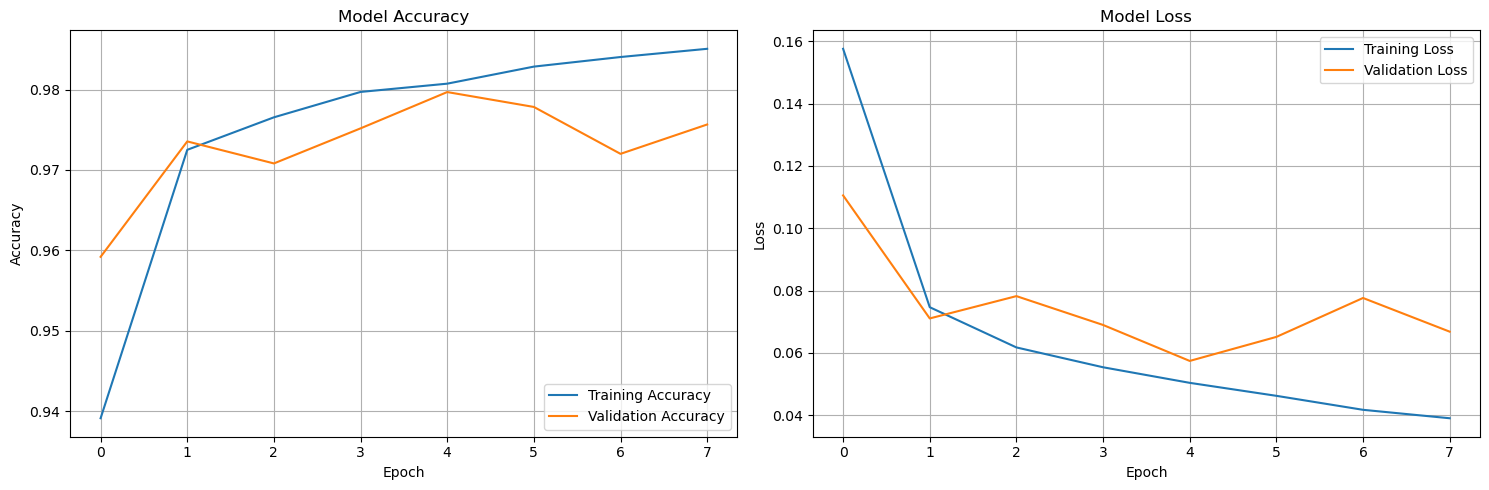


Generating predictions for test data...
10905/10905 [==============================] - 172s 16ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake       0.85      0.96      0.90      5492
        Real       0.96      0.83      0.89      5413

    accuracy                           0.90     10905
   macro avg       0.90      0.89      0.89     10905
weighted avg       0.90      0.90      0.89     10905


Generating confusion matrix...


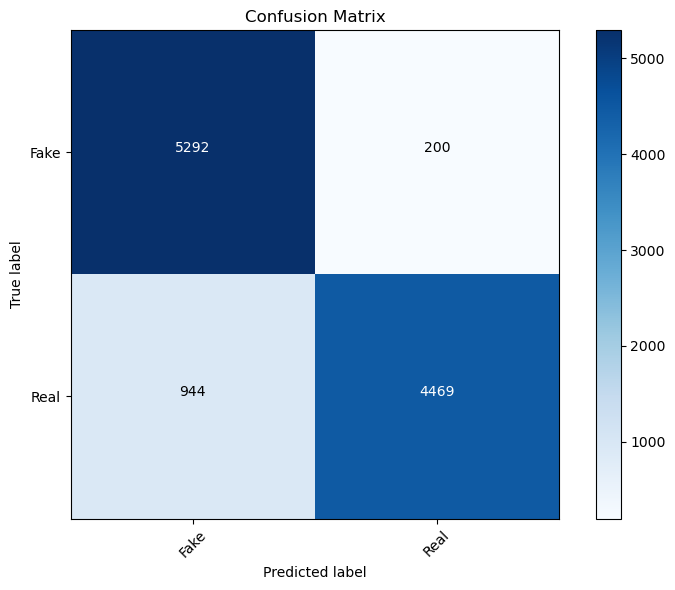


Generating ROC curve...


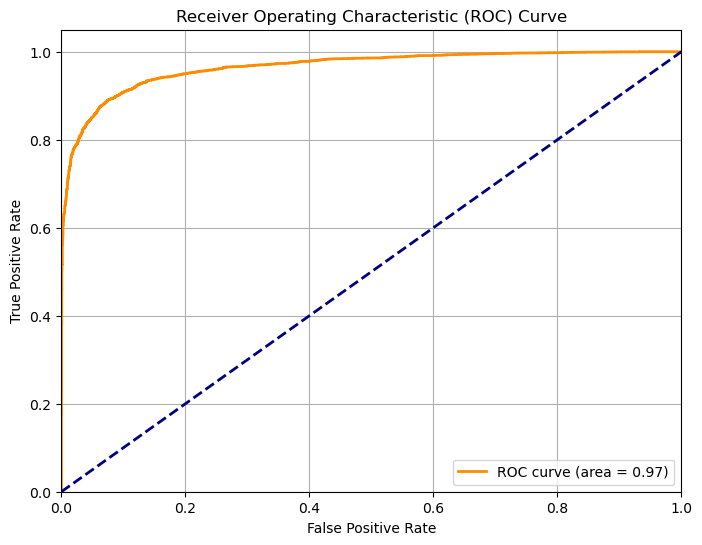

Area Under the ROC Curve (AUC): 0.9653

Generating precision, recall, and F1 score plot...


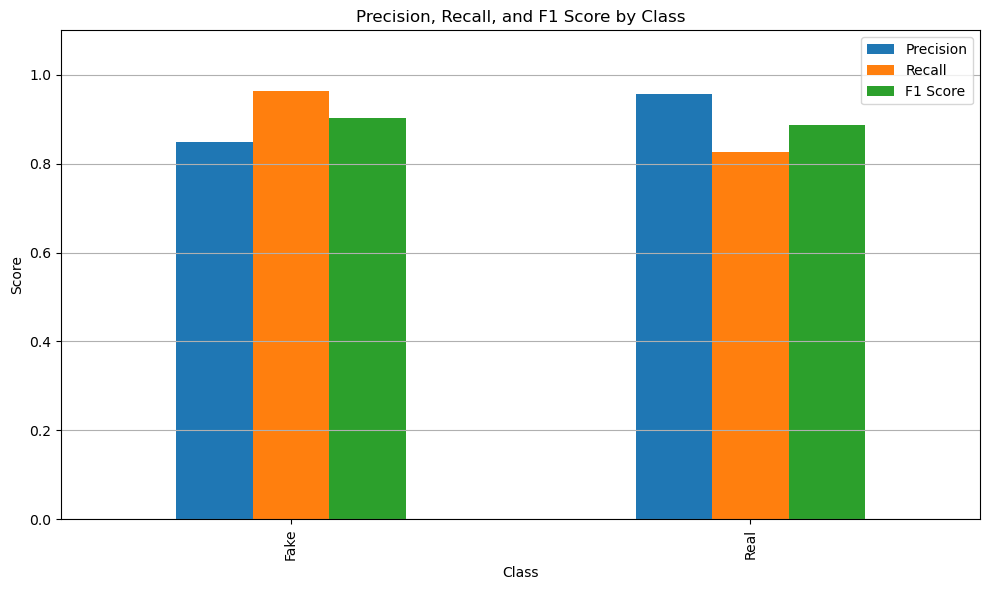


===== EVALUATION COMPLETE =====


In [23]:
# Evaluate the model and display visualizations
print("\n===== MODEL EVALUATION AND VISUALIZATION =====\n")

# Plot accuracy and loss curves
print("Plotting accuracy and loss curves...")
plot_accuracy_loss(history_icv3)

# Get predictions for test data
print("\nGenerating predictions for test data...")
y_true, y_pred, y_pred_probs = get_predictions(model_icv3, test_data)

# classification report
print("\nClassification Report:")
class_names = list(test_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# plot confusion matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names=class_names, title='Confusion Matrix')

# Plot ROC curve
print("\nGenerating ROC curve...")
roc_auc = plot_roc_curve(y_true, y_pred_probs)
print(f"Area Under the ROC Curve (AUC): {roc_auc:.4f}")

# Calculate and plot precision, recall, F1 score
print("\nGenerating precision, recall, and F1 score plot...")
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
plot_precision_recall_f1(precision, recall, f1, class_names)

print("\n===== EVALUATION COMPLETE =====")